In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib import rcParams

### CONFIGURAÇÕES INICIAIS

In [28]:
# Configurações de estilo melhoradas
plt.style.use('seaborn-v0_8')
rcParams.update({
    'font.family': 'DejaVu Sans',
    'figure.figsize': (12, 8),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
sns.set_palette("husl")

### CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [29]:
# Carregar dados principais
def carregar_dados():
    """Carrega os dados principais e o dicionário de variáveis"""
    try:
        # Carregar dataset principal
        df = pd.read_csv('../../Bases/Criados/base_preenchida.csv', 
                        encoding='utf-8')
        
        # Carregar dicionário de variáveis
        nomes_colunas = pd.read_csv('../../Bases/Originais/PNS_titulos.csv',
                                  sep=';',
                                  encoding='latin1')
        
        # Criar mapeamento código -> descrição
        nome_por_codigo = dict(zip(nomes_colunas.iloc[:, 0], nomes_colunas.iloc[:, 1]))
        
        return df, nome_por_codigo
        
    except Exception as e:
        print(f"Erro ao carregar dados: {str(e)}")
        exit()

# Carregar os dados
df, nome_por_codigo = carregar_dados()

### IDENTIFICAÇÃO DE DADOS FALTANTES

In [30]:
# Identificar colunas com dados faltantes
def analisar_faltantes(df):
    """Realiza análise completa de dados faltantes"""
    # Identificar colunas com faltantes
    dados_faltantes = df.isnull().sum()
    colunas_com_faltantes = dados_faltantes[dados_faltantes > 0]
    
    # Ordenar por quantidade de faltantes (decrescente)
    colunas_com_faltantes = colunas_com_faltantes.sort_values(ascending=False)
    
    # Calcular estatísticas
    total_colunas = len(df.columns)
    colunas_sem_faltantes = total_colunas - len(colunas_com_faltantes)
    total_faltantes = dados_faltantes.sum()
    percentual_total = (total_faltantes / (len(df) * total_colunas)) * 100
    
    return {
        'colunas_com_faltantes': colunas_com_faltantes,
        'colunas_sem_faltantes': [col for col in df.columns if col not in colunas_com_faltantes],
        'total_faltantes': total_faltantes,
        'percentual_total': percentual_total
    }

# Executar análise
analise = analisar_faltantes(df)

### FUNÇÃO PARA GRÁFICOS RELATIVOS (100% STACKED)

) missing from font(s) DejaVu Sans.pykernel_13412\1677152823.py:44: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.pykernel_13412\1677152823.py:47: UserWarning: Glyph 13 (
  plt.savefig(f'{save_dir}/dados_faltantes_grupo_{i}.png',


<Figure size 1400x800 with 0 Axes>

) missing from font(s) DejaVu Sans.on\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


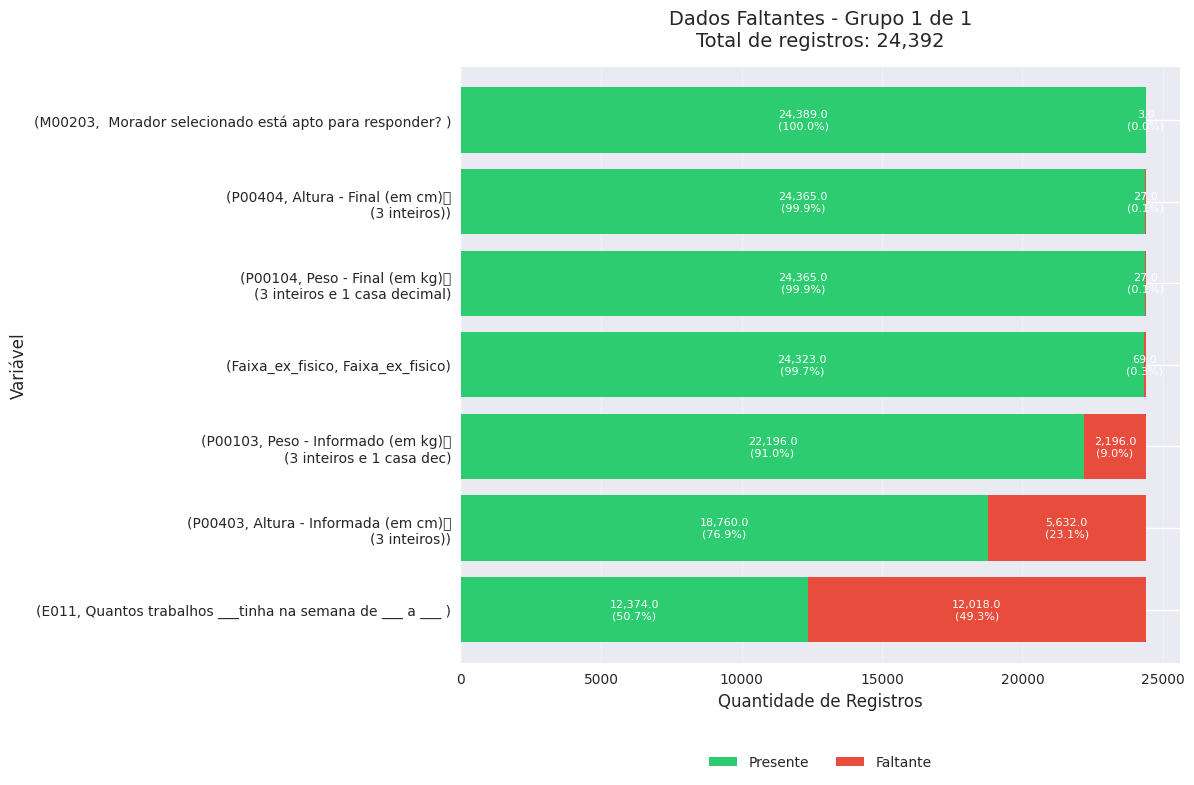

In [31]:
def plotar_faltantes(df, colunas_com_faltantes, nome_por_codigo, save_dir='Imagens'):
    """Gera e salva gráficos de dados faltantes"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Dividir colunas em grupos para visualização
    grupos = np.array_split(colunas_com_faltantes.index, 
                          np.ceil(len(colunas_com_faltantes)/15))
    
    for i, grupo in enumerate(grupos, 1):
        plt.figure(figsize=(14, 8))
        
        # Preparar dados
        dados_plot = pd.DataFrame({
            'Coluna': grupo,
            'Presente': [len(df) - df[col].isna().sum() for col in grupo],
            'Faltante': [df[col].isna().sum() for col in grupo],
            'Descricao': [nome_por_codigo.get(col, col)[:50] for col in grupo]
        })
        
        # Plotar gráfico de barras empilhadas
        ax = dados_plot.set_index(['Coluna', 'Descricao']).plot(
            kind='barh', 
            stacked=True,
            color=['#2ecc71', '#e74c3c'],
            width=0.8
        )
        
        # Adicionar rótulos
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                ax.annotate(f"{width:,}\n({width/len(df)*100:.1f}%)",
                           (p.get_x() + width/2, p.get_y() + p.get_height()/2),
                           ha='center', va='center', color='white', fontsize=8)
        
        # Configurações do gráfico
        plt.title(f'Dados Faltantes - Grupo {i} de {len(grupos)}\nTotal de registros: {len(df):,}',
                pad=15)
        plt.xlabel('Quantidade de Registros')
        plt.ylabel('Variável')
        plt.legend(['Presente', 'Faltante'], loc='lower center', 
                  bbox_to_anchor=(0.5, -0.2), ncol=2)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        
        # Salvar gráfico
        plt.savefig(f'{save_dir}/dados_faltantes_grupo_{i}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# Gerar gráficos
plotar_faltantes(df, analise['colunas_com_faltantes'], nome_por_codigo)

### ANÁLISE DE DADOS FALTANTES

In [32]:
def gerar_relatorio(analise, nome_por_codigo, filename='relatorio_dados_faltantes.txt'):
    """Gera relatório completo em arquivo texto"""
    with open(filename, 'w', encoding='utf-8') as f:
        # Cabeçalho
        f.write("RELATÓRIO DE DADOS FALTANTES\n")
        f.write("="*60 + "\n\n")
        
        # Estatísticas gerais
        f.write("ESTATÍSTICAS GERAIS:\n")
        f.write("-"*60 + "\n")
        f.write(f"Total de variáveis analisadas: {len(analise['colunas_com_faltantes']) + len(analise['colunas_sem_faltantes'])}\n")
        f.write(f"Variáveis sem dados faltantes: {len(analise['colunas_sem_faltantes'])}\n")
        f.write(f"Variáveis com dados faltantes: {len(analise['colunas_com_faltantes'])}\n")
        f.write(f"Total de valores faltantes: {analise['total_faltantes']:,}\n")
        f.write(f"Percentual total de dados faltantes: {analise['percentual_total']:.2f}%\n\n")
        
        # Variáveis sem faltantes
        f.write("VARIÁVEIS SEM DADOS FALTANTES:\n")
        f.write("-"*60 + "\n")
        for col in analise['colunas_sem_faltantes']:
            f.write(f"{col} - {nome_por_codigo.get(col, 'Descrição não disponível')}\n")
        
        # Variáveis com faltantes
        f.write("\n\nVARIÁVEIS COM DADOS FALTANTES:\n")
        f.write("-"*60 + "\n")
        f.write(f"{'Variável':<15} {'Descrição':<50} {'Faltantes':>10} {'% Faltantes':>12}\n")
        f.write("-"*90 + "\n")
        
        for col, qtd in analise['colunas_com_faltantes'].items():
            desc = nome_por_codigo.get(col, 'Descrição não disponível')
            percent = (qtd / len(df)) * 100
            f.write(f"{col:<15} {desc[:50]:<50} {qtd:>10,} {percent:>10.2f}%\n")

# Gerar relatório
gerar_relatorio(analise, nome_por_codigo)
print("Relatório salvo em 'relatorio_dados_faltantes.txt'")

print("\nAnálise concluída com sucesso!")

Relatório salvo em 'relatorio_dados_faltantes.txt'

Análise concluída com sucesso!
